<a href="https://colab.research.google.com/github/neillinehan/NeilLinehanPortfolio/blob/main/wavelets_for_irregular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [35]:
def gaussian_kernel(t, out=None):
    np.square(t, out=t)
    t *= -0.5
    return np.exp(t, out=out)


def DoG_wavelet(t, s, start, end,dt):
    # Build a k-d tree for efficient nearest neighbor search
    tree = cKDTree(t[:, None])

    # Find the indices of the closest 'bandwidth' number of points for each point in 't'
    _, indices = tree.query(t[start:end, None], k=300#s*6*1.87/dt,
                            ) #set the number of data points for the guassian to extend 6 standard deviations

    # Sort the indices along the second axis
    indices.sort(axis=1)

    # Calculate the pairwise distances and apply the Gaussian kernel
    diff = (t[indices] - t[start:end, None]) / s
    gaussian_kernel(diff, out=diff)

    # Compute DoG
    sprime_const = 1/(1.87)**2
    DoG = (diff / np.sum(diff, axis=1, keepdims=True)) -\
      (np.power(diff, sprime_const) / np.sum(np.power(diff, sprime_const), axis=1, keepdims=True))
    return DoG

# This function calculates the continuous wavelet transform (CWT) of the Difference of Gaussians (DoG).
# The CWT is a time-frequency analysis method that involves calculating the inner product of a signal with scaled and shifted versions of a wavelet function.
def calc_cwt_DoG(DoG,signal,start,end):
  #htau = np.sqrt(np.sum(DoG**2,axis=1))  # Calculates the norm of each column in 'DoG'
  Twavx_tau = np.sum(DoG * signal[start:end,None], axis=1) / np.sqrt(np.sum(DoG**2,axis=1))[:,None]  # Calculates the CWT by multiplying each column in 'DoG' with 'signal', and summing up along each row
  #Twavx_tau = np.sum((DoG / 1 ) * signal[start:end,None], axis=1)  # Calculates the CWT by multiplying each column in 'DoG' with 'signal', and summing up along each row

  return Twavx_tau

def compute_cwt_DoG(t, signal, s_list,start,end,dt):
    results = []
    for s in s_list:
        DoG = DoG_wavelet(t, s,start,end,dt)
        result = calc_cwt_DoG(DoG, signal,start,end)
        results.append(result)
    return np.asarray(results)

In [36]:
def DoG_wavelet_cwt(t, s,signal, start, end,dt):
    # Build a k-d tree for efficient nearest neighbor search
    tree = cKDTree(t[:, None])

    # Find the indices of the closest 'bandwidth' number of points for each point in 't'
    _, indices = tree.query(t[start:end, None], k=s*6*1.87/dt,
                            workers=-1,
                            ) #set the number of data points for the guassian to extend 6 standard deviations

    # Sort the indices along the second axis
    indices.sort(axis=1)

    # Calculate the pairwise distances and apply the Gaussian kernel
    diff = (t[indices] - t[start:end, None]) / s
    gaussian_kernel(diff, out=diff)

    # Compute DoG
    sprime_const = (1.87)**-2
    DoG = (diff / np.sum(diff, axis=1, keepdims=True)) -\
      (np.power(diff, sprime_const) / np.sum(np.power(diff, sprime_const), axis=1, keepdims=True))
    DoG = np.sum(DoG *np.sqrt(dt/s) * signal[indices],axis=1) / np.sqrt(np.sum(DoG**2,axis=1))
    return DoG

In [37]:
def compute_cwt_DoG(t, signal, s_list,start,end,dt):
    results = []
    for s in s_list:
        cwt = DoG_wavelet_cwt(t, s,signal,start,end,dt)
        results.append(cwt)
    return np.asarray(results)

In [38]:


# Initialize the start time
start_time = pd.Timestamp('2023-01-01')

# Initialize an empty list to hold the timestamps
timestamps = []

# Generate data for 100 days
for _ in range(100):
    # Determine the duration of the active and inactive periods
    active_hours = 14 + np.random.uniform(-1, 1)
    inactive_hours = 10 + np.random.uniform(-1, 1)

    # Generate timestamps for the active period
    end_time = start_time + pd.Timedelta(hours=active_hours)
    while start_time < end_time:
        timestamps.append(start_time)
        start_time += pd.Timedelta(seconds=60) + pd.Timedelta(seconds=np.random.uniform(-25, 25))

    # Skip the inactive period
    start_time += pd.Timedelta(hours=inactive_hours)

# Convert the list of timestamps to a pandas Series
t = pd.Series(timestamps)#.to_frame()
df = t - t[0]
t_numeric = df.dt.total_seconds()
t = t_numeric.values

In [39]:


# Create a time array
dt = 60
min_scale = dt *2
X = .25/6/1.87
scales_per_octave = 10
max_scale = dt*30

#t = np.arange(0, max_scale/X, dt)  # 60 second min period

# Create a signal with a frequency of  Hz cycle/s 1 cycle/s time units
period1 = dt*20
period2 = dt*10
signal1 = np.sin(2*np.pi/period1*t[:len(t)//2])
signal2 = np.sin(2*np.pi/period2*t[len(t)//2:])
signal = np.concatenate((signal1, signal2))
num_octaves = np.log2(max_scale / min_scale)
num_scales = math.ceil(np.log2(max_scale / min_scale) * scales_per_octave)
J = num_scales
# Define the scales as periods
scales = min_scale * 2**(np.arange(0,J+1)/scales_per_octave)

In [40]:
results = compute_cwt_DoG(t, signal, scales, 0, len(t),dt)

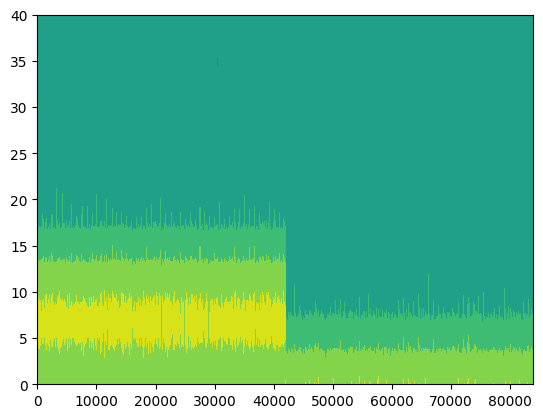

In [43]:
plt.contourf(results)

# Generate difference of Gaussian wavelets - attempt at memory optimization


In [41]:
def DoG_wavelet(t, s, dt, start=0, end=None):
    if end is None:
        end = len(t)
    B = 1.15
    k = int(s * 6 * B / dt)
    # Create an array of start indices
    starts = np.arange(len(t)) - k//2
    starts = np.maximum(starts, 0)

    # Create an array of end indices
    ends = starts + k
    ends = np.minimum(ends, len(t))

    # Adjust starts if ends - starts is less than k
    starts = np.maximum(ends - k, 0)

    # Create a matrix of indices
    mat1 = np.arange(k) + starts[:, np.newaxis]

    # Calculate the pairwise distances and apply the Gaussian kernel

    #find pairwise difference matrix: (t-tau)/s
    mat1 = ((t[start:end, None] - t[mat1]) / s).astype(np.complex64)

    #finding complex gaussian k((t-tau)/s)
    #e ^ -((t-tau)/s) ^2 + ((t-tau)/s) i
    mat2 = np.exp(-mat1*mat1/2- mat1 * 1j)
    #normalize weights of complex guassian k((t-tau)/s)/SUM(k(t-tau)/s)
    mat2 /= np.sum(mat2, axis=1, keepdims=True)  # normalize in-place

    #finding complex gaussian k((t-tau)/s'), s'=1.87 s
    #(t-tau)/s'
    mat1 /= B  # reuse 'diff' variable to save memory
    #e ^ -((t-tau)/s') ^2 - ((t-tau)/s') i
    mat1 = np.exp(-mat1*mat1/2 - mat1 * 1j)
    #normalize weights of complex guassian k((t-tau)/s')/SUM(k(t-tau)/s')
    mat1 /= np.sum(mat1, axis=1, keepdims=True)  # normalize in-place

    #find DoG wavelet Ns - Ns'
    mat2 = mat2 - mat1
    #find DoG wavelet Ns - Ns' - normalized
    mat2 /= np.sqrt(np.sum(abs(mat2)**2,axis=1))[:, None]

    return mat2


##experimenting with inputting the signal to optimize memory needs.

In [44]:
def DoG_wavelet(t, s, dt,signal, start=0, end=None):
    if end is None:
        end = len(t)
    k = int(s * 6 * 1.87 / dt)
    # Create an array of start indices
    starts = np.arange(len(t)) - k//2
    starts = np.maximum(starts, 0)

    # Create an array of end indices
    ends = starts + k
    ends = np.minimum(ends, len(t))

    # Adjust starts if ends - starts is less than k
    starts = np.maximum(ends - k, 0)

    # Create a matrix of indices
    mat1 = np.arange(k) + starts[:, np.newaxis]

    # Calculate the pairwise distances and apply the Gaussian kernel

    #find pairwise difference matrix: (t-tau)/s
    mat1 = ((t[start:end, None] - t[mat1]) / s).astype(np.complex64)

    #finding complex gaussian k((t-tau)/s)
    #e ^ -((t-tau)/s) ^2 + ((t-tau)/s) i
    mat2 = np.exp(-mat1*mat1 - mat1 * 1j)
    #normalize weights of complex guassian k((t-tau)/s)/SUM(k(t-tau)/s)
    mat2 /= np.sum(mat2, axis=1, keepdims=True)  # normalize in-place

    #finding complex gaussian k((t-tau)/s'), s'=1.87 s
    #(t-tau)/s'
    mat1 /= 1.87  # reuse 'diff' variable to save memory
    #e ^ -((t-tau)/s') ^2 - ((t-tau)/s') i
    mat1 = np.exp(-mat1*mat1 - mat1 * 1j)
    #normalize weights of complex guassian k((t-tau)/s')/SUM(k(t-tau)/s')
    mat1 /= np.sum(mat1, axis=1, keepdims=True)  # normalize in-place

    #find DoG wavelet Ns - Ns'
    mat2 = mat2 - mat1
    #find DoG wavelet Ns - Ns' - normalized
    mat2 /= np.sqrt(np.sum(abs(mat2)**2,axis=1))[:, None]
    mat2 = np.sum(mat2 * signal[np.arange(k) + starts[:, np.newaxis]],axis=1)

    return mat2


In [45]:
DoG_120 = DoG_wavelet(t[:],240,60)

In [18]:
s = 240
dt = 60

In [19]:
k = int(s * 6 *1.15  / dt)
    # Create an array of start indices
starts = np.arange(len(t)) - k//2
starts = np.maximum(starts, 0)

    # Create an array of end indices
ends = starts + k
ends = np.minimum(ends, len(t))

    # Adjust starts if ends - starts is less than k
starts = np.maximum(ends - k, 0)

    # Create a matrix of indices
mat1 = np.arange(k) + starts[:, np.newaxis]

In [20]:
mat = []
scales = np.linspace(350,370,20)
for s in scales:
  mat.append(abs(np.sum(DoG_120*np.cos(t[mat1]*np.pi/s),axis=1))**2)

In [21]:
mat = np.asarray(mat)
mat = np.sum(mat,axis=1)

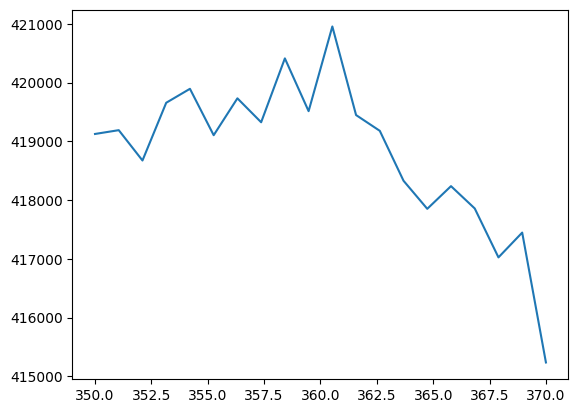

In [22]:
plt.plot(scales,mat)

In [23]:
s_to_p = scales[np.argmax(mat)]/240

In [24]:
scales[np.argmax(mat)]

360.5263157894737

In [25]:
scales[np.argmax(mat)]/240

1.5021929824561404

In [26]:
from scipy import interpolate

def scale_wavelet(wavelet, new_length):
    old_indices = np.linspace(0, 1, len(wavelet))
    new_indices = np.linspace(0, 1, new_length)
    interpolator = interpolate.interp1d(old_indices, wavelet)
    return interpolator(new_indices)

# Assuming mother_wavelet is your mother wavelet
mother_wavelet = DoG_120[400]  # for example

# Scale the mother wavelet to double its length
scaled_wavelet = scale_wavelet(mother_wavelet, len(mother_wavelet) * 2)


In [27]:
old_indices = t[mat1[500]]
new_indices = t[mat1[501]]
interpolator = interpolate.interp1d(old_indices, DoG_120[500])
moved_Wavelet = interpolator(new_indices)

ValueError: A value (30342.751479801) in x_new is above the interpolation range's maximum value (30264.322120872).

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


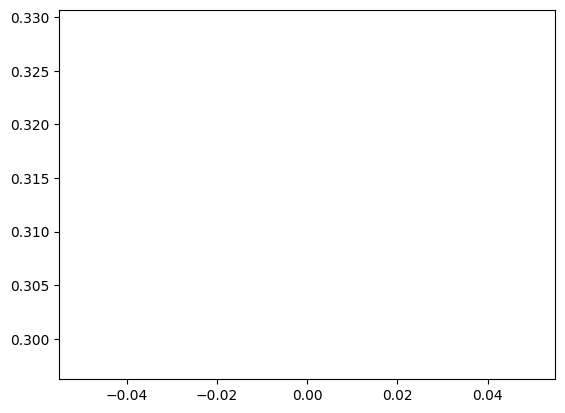

In [46]:
plt.plot(DoG_120[100])

In [ ]:
wavelet_test = DoG_120

In [ ]:
real_parts = np.real(wavelet_test)
imag_parts = np.imag(wavelet_test)

# Check orthogonality
inner_products = np.einsum('ij,ij->i', real_parts, imag_parts)
orthogonal = np.isclose(inner_products, 0)

# Check vanishing moment
real_means = np.mean(real_parts, axis=1)
imag_means = np.mean(imag_parts, axis=1)
vanishing_moment = np.isclose(real_means, 0) & np.isclose(imag_means, 0)

# Check mean
real_integrals = np.trapz(real_parts, axis=1)
imag_integrals = np.trapz(imag_parts, axis=1)
zero_mean = np.isclose(real_integrals, 0) & np.isclose(imag_integrals, 0)

# Check energy
# Compute magnitudes of complex wavelets
magnitudes = np.abs(wavelet_test)

# Square magnitudes
squared_magnitudes = np.square(magnitudes)

# Sum squared magnitudes along each row
energies = np.sum(squared_magnitudes, axis=1)
tolerance = .01*60  # Adjust this value as needed

# Check orthogonality
orthogonal = np.isclose(inner_products, 0, atol=tolerance)

# Check vanishing moment
vanishing_moment = np.isclose(real_means, 0, atol=tolerance) & np.isclose(imag_means, 0, atol=tolerance)

# Check mean
zero_mean = np.isclose(real_integrals, 0, atol=tolerance) & np.isclose(imag_integrals, 0, atol=tolerance)

# Check energy
unit_energy = np.isclose(energies, 1, atol=tolerance)
# Count the number of wavelets that pass each check
num_orthogonal = np.sum(orthogonal)
num_vanishing_moment = np.sum(vanishing_moment)
num_zero_mean = np.sum(zero_mean)
num_unit_energy = np.sum(unit_energy)

# Calculate the percentage of wavelets that pass each check
perc_orthogonal = num_orthogonal / len(wavelet_test) * 100
perc_vanishing_moment = num_vanishing_moment / len(wavelet_test) * 100
perc_zero_mean = num_zero_mean / len(wavelet_test) * 100
perc_unit_energy = num_unit_energy / len(wavelet_test) * 100

# Print summary results
print(f"{perc_orthogonal}% of wavelets have orthogonal real and imaginary parts.")
print(f"{perc_vanishing_moment}% of wavelets have one vanishing moment.")
print(f"{perc_zero_mean}% of wavelets have a mean of zero.")
print(f"{perc_unit_energy}% of wavelets have an energy of 1.")


100.0% of wavelets have orthogonal real and imaginary parts.
100.0% of wavelets have one vanishing moment.
100.0% of wavelets have a mean of zero.
100.0% of wavelets have an energy of 1.
